<a href="https://colab.research.google.com/github/jefftrojan/chatbot-app/blob/main/cropbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Making sure this runs on GPU if available
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Prevents full memory allocation
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print(e)


2025-02-26 04:19:43.606729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740536383.621455   47535 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740536383.625298   47535 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 04:19:43.638534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Memory growth enabled for GPU


In [3]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Checking if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Now I will load my model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Loading the BERT model and moving it to the GPU if available
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)


Using device: cuda


In [4]:
#Importing all the necessary libraries
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

[nltk_data] Downloading package punkt to /home/begati/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/begati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df = pd.read_csv("data/crop_diseases.csv")
df.head()

,Questions,Answers,Patterns,Tags
0,What is crop rotation?,Crop rotation is the practice of growing diffe...,Can you explain the concept of crop rotation?,Crop Rotation
1,What is the primary benefit of crop rotation?,The primary benefit of crop rotation is the im...,Why is crop rotation beneficial?,Soil Health
2,What is a cover crop?,A cover crop is a plant grown primarily to pro...,What is the purpose of a cover crop?,Cover Crops
3,What are common cover crops?,"Common cover crops include clover, rye, and ve...",Can you name some examples of cover crops?,Crop Examples
4,What is monoculture?,Monoculture is the agricultural practice of gr...,What does monoculture mean?,Monoculture


In [6]:
# !pip install wordcloud ---use this if you don't have wordcloud installed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud



# Display basic info
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display basic statistics
print("\nDataset Statistics:")
print(df.describe(include='all'))

# Count unique tags
print("\nUnique Tags:")
print(df['Tags'].value_counts())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Questions  45 non-null     object
 1   Answers    45 non-null     object
 2   Patterns   45 non-null     object
 3   Tags       45 non-null     object
dtypes: object(4)
memory usage: 1.5+ KB
None

Missing Values:
Questions    0
Answers      0
Patterns     0
Tags         0
dtype: int64

Dataset Statistics:
                     Questions  \
count                       45   
unique                      45   
top     What is crop rotation?   
freq                         1   

                                                  Answers  \
count                                                  45   
unique                                                 45   
top     Crop rotation is the practice of growing diffe...   
freq                                                    1   

                 

/tmp/ipykernel_47535/2581390889.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['Tags'], order=df['Tags'].value_counts().index, palette='viridis')


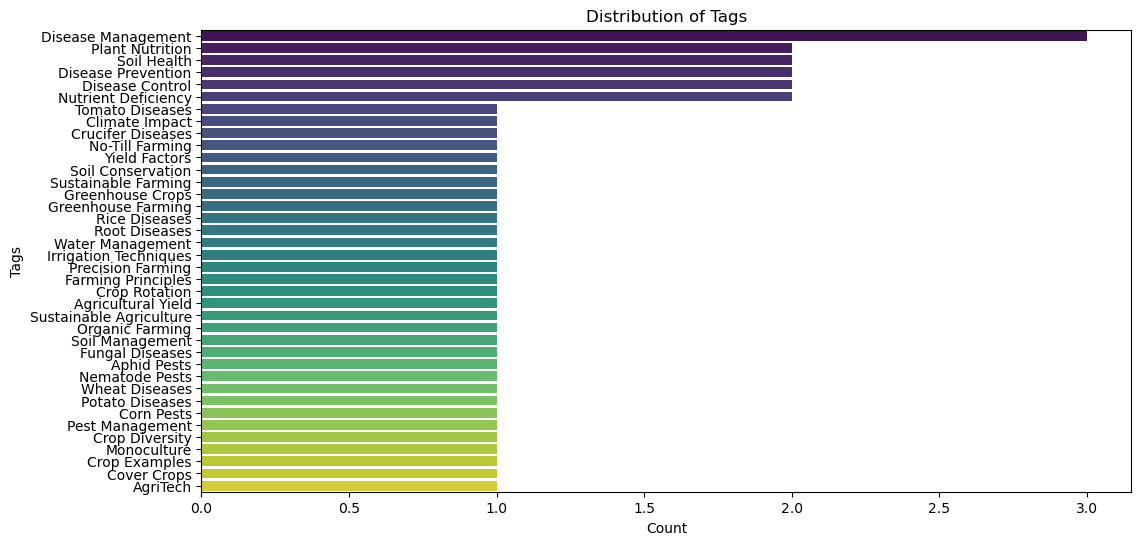

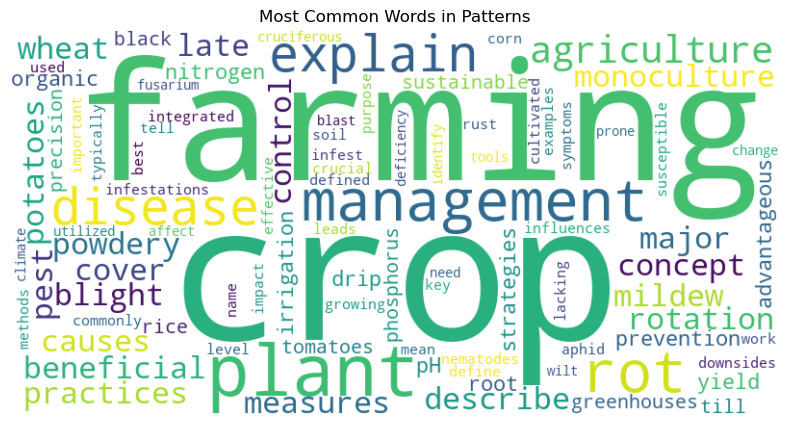

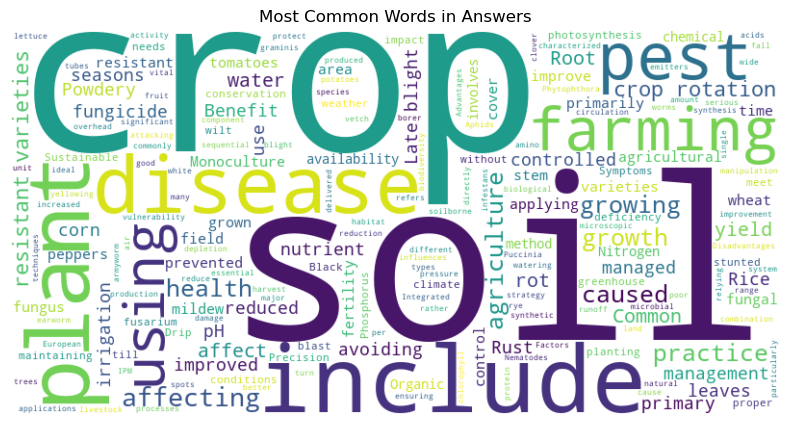

In [7]:
# Visualizing the tag distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Tags'], order=df['Tags'].value_counts().index, palette='viridis')
plt.xlabel("Count")
plt.ylabel("Tags")
plt.title("Distribution of Tags")
plt.show()

# Word cloud for Patterns
text = " ".join(df['Patterns'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Patterns")
plt.show()

# Word cloud for Answers
text_answers = " ".join(df['Answers'].astype(str))
wordcloud_answers = WordCloud(width=800, height=400, background_color="white").generate(text_answers)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_answers, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Answers")
plt.show()

## Data Preprocessing

In [9]:

# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("crops.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Crop Rotation'], 'patterns': ['what is crop rotation', 'can you explain the concept of crop rotation?'], 'responses': ['Crop rotation is the practice of growing different types of crops in the same area in sequential seasons to improve soil health and reduce pests.']}, {'tags': ['Soil Health'], 'patterns': ['what is the primary benefit of crop rotation', 'why is crop rotation beneficial?'], 'responses': ['The primary benefit of crop rotation is the improvement of soil fertility and the reduction of soilborne diseases and pests.']}]


## Doing some data preprocessing

In [11]:
import pickle
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))  # Load English stopwords

words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True).to(device)  # Move input to GPU
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().cpu().numpy()  # Move back to CPU for NumPy

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            filtered_words = [word.lower() for word in word_list if word.lower() not in stop_words]  # Remove stopwords
            words.extend(filtered_words)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

# Lemmatization and sorting
words = [lemmatizer.lemmatize(word) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

# Save processed data
pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))


[nltk_data] Downloading package stopwords to /home/begati/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/begati/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:


# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

## Model creation with hyperparameter tuning

In [14]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()
0

/home/begati/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740536395.352993   47535 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,158 (426.40 KB)

 Trainable params: 109,158 (426.40 KB)

 Non-trainable params: 0 (0.00 B)

0

I have used various hyperparameters and these ones are the ones that are the best based on the ones I used

In [16]:
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50


I0000 00:00:1740536397.175004   47610 service.cc:148] XLA service 0x7f9184006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740536397.175041   47610 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-02-26 04:19:57.204887: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740536397.298352   47610 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/8 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 3.6473

I0000 00:00:1740536398.653834   47610 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0095 - loss: 3.6855  
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1149 - loss: 3.5058 
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0712 - loss: 3.3674 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1976 - loss: 3.3001 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.1732 - loss: 3.1363 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.3450 - loss: 2.8773 
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.3029 - loss: 2.7095 
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.7778 - Recall: 0.0198 - accuracy: 0.3852 - loss: 

Training Done


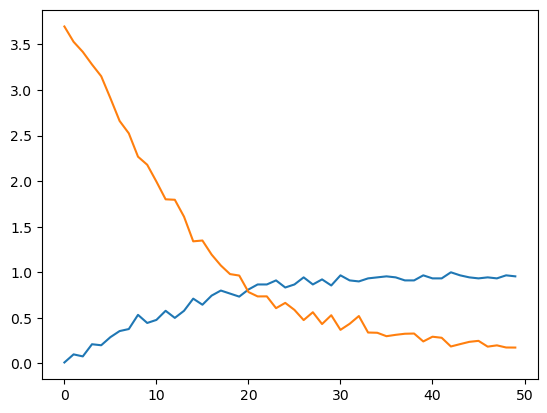

In [17]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
plt.show()


In [18]:
# Load the model for prediction
model = load_model('chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand. Please provide a topic that is related to crops"

print("ChatBot is Active")
#run this  if you want to test the chat bot on here
# while True:
#     message = input("")
#     if message.lower() in ['quit', 'exit']:
#         print("Goodbye")
#         break
#     ints = predict_class(message)
#     if ints:
#         res = get_response(ints, dict_)
#         print(f"Bot: {res}")
#     else:
#         print("Bot: Sorry, I don't understand.")

ChatBot is Active


## Evaluating the Model

#### BLEU Score

In [21]:
import random

# Load intents from your training dataset
intents = dict_['intents']

# Create test data (20% of the patterns)
test_data = []
for intent in intents:
    for pattern in intent['patterns']:
        test_data.append((pattern, intent['responses'][0]))  # Assume first response is the expected one

# Shuffle and take a subset for evaluation
random.shuffle(test_data)
test_data = test_data[:int(len(test_data) * 0.2)]  # Use 20% of data as test set


In [22]:
def generate_response(model, input_text):
    """
    Generate a response from the chatbot model given input_text.
    
    model: Your trained chatbot model
    input_text: User's input message
    """
    input_embedding = get_bert_embedding(input_text)  # Get BERT embedding for input
    prediction = model.predict(input_embedding)  # Predict intent
    predicted_index = prediction.argmax()  # Get index of highest probability
    predicted_intent = classes[predicted_index]  # Map to class label
    
    # Get a response from intents dictionary
    for intent in dict_['intents']:
        if predicted_intent in intent['tags']:
            return random.choice(intent['responses'])  # Return a random valid response

    return "I'm not sure how to respond to that."


In [23]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def evaluate_bleu(model, test_data, tokenizer):
    """
    Compute BLEU score for chatbot responses.
    
    model: Your trained chatbot model
    test_data: List of tuples (input_text, expected_response)
    tokenizer: Tokenizer used for processing text
    """
    actual_responses = []
    generated_responses = []
    
    for input_text, expected_response in test_data:
        # Get model's response
        predicted_response = generate_response(model, input_text)  
        
        # Tokenize responses
        expected_tokens = tokenizer.tokenize(expected_response.lower())
        predicted_tokens = tokenizer.tokenize(predicted_response.lower())

        # Store responses for corpus-level BLEU
        actual_responses.append([expected_tokens])  # BLEU expects list of references
        generated_responses.append(predicted_tokens)

    # Compute BLEU scores
    bleu_1 = corpus_bleu(actual_responses, generated_responses, weights=(1.0, 0, 0, 0))  # Unigram BLEU
    bleu_2 = corpus_bleu(actual_responses, generated_responses, weights=(0.5, 0.5, 0, 0))  # Bi-gram BLEU
    
    print(f"BLEU-1 Score: {bleu_1:.4f}")
    print(f"BLEU-2 Score: {bleu_2:.4f}")

    return bleu_1, bleu_2

evaluate_bleu(model, test_data, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
BLEU-1 Score: 0.8386
BLEU-2 Score: 0.8109


(0.8386079602171292, 0.8108628565865262)

This is a very solid and beaurtiful bleu score

#### F1 Score

In [26]:
from sklearn.metrics import f1_score

def evaluate_f1(model, test_data, tokenizer):
    """
    Compute F1 Score for chatbot responses.
    
    model: Your trained chatbot model
    test_data: List of tuples (input_text, expected_response)
    tokenizer: Tokenizer used for processing text
    """
    y_true = []  # True responses
    y_pred = []  # Predicted responses
    
    for input_text, expected_response in test_data:
        # Get model's response
        predicted_response = generate_response(model, input_text)
        
        # Tokenize responses
        expected_tokens = tokenizer.tokenize(expected_response.lower())
        predicted_tokens = tokenizer.tokenize(predicted_response.lower())
        
        # Convert tokens back to string (or use word-level if your model is word-based)
        expected_response = ' '.join(expected_tokens)
        predicted_response = ' '.join(predicted_tokens)
        
        y_true.append(expected_response)
        y_pred.append(predicted_response)
    
    # Compute F1 score
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)  # Set zero_division to 1 to handle 0 divisions
    
    print(f"F1 Score: {f1:.4f}")
    
    return f1
evaluate_f1(model, test_data, tokenizer)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
F1 Score: 0.7222


0.7222222222222222

This Score proves  that my model is correct and running well